In [1]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from datasets import load_dataset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import os
import random
from matplotlib.colors import LinearSegmentedColormap



In [2]:
# Define the number of epochs
num_epochs = 20

# Define the batch size
batch_size = 16

# Define the input shape
input_shape = (224, 224)

In [3]:
class AffectNetHqDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
def heatmap_generator(image):
    face_locations = face_recognition.face_locations(image)

    # Load the pre-trained facial landmark model
    face_landmarks_list = face_recognition.face_landmarks(image, face_locations)

    h,w = image.shape[:2]
    lm = np.zeros([h,w])

    # Draw facial landmarks on the image
    for face_landmarks in face_landmarks_list:
        for landmark_type, landmarks in face_landmarks.items():
            for (x, y) in landmarks:
                if x < h and y < w :
                    lm[y,x] = 1

    heatmap = cv2.GaussianBlur(lm, [59,59], 3)         

    return heatmap

def generate_batch_heatmaps(images, heatmap_generator):
    batch_heatmaps = torch.zeros_like(images)

    for i in range(images.size(0)):
        # Convertir le tenseur PyTorch en tableau NumPy pour l'image i
        image_np = images[i].permute(1, 2, 0).cpu().detach().numpy()
        image_np = (image_np * 255).astype(np.uint8) if image_np.dtype != np.uint8 else image_np
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
            
        # Générer la heatmap pour l'image actuelle
        heatmap_np = heatmap_generator(image_np)
        heatmap_tensor = torch.from_numpy(heatmap_np).float().unsqueeze(0)

        # Normaliser la heatmap et l'adapter à la taille de l'image
        heatmap_tensor = heatmap_tensor / torch.max(heatmap_tensor)
        heatmap_tensor = heatmap_tensor.repeat(3, 1, 1)

        # Stocker la heatmap dans le tenseur batch
        batch_heatmaps[i] = heatmap_tensor
    
    return batch_heatmaps

In [5]:
import torch
import torch.nn as nn

class PrivilegedAttributionLoss(nn.Module):
    def __init__(self):
        super(PrivilegedAttributionLoss, self).__init__()

    def forward(self, attribution_maps, prior_maps):
        # Add a small value to standard deviation to avoid division by zero
        epsilon = 1e-8

        # Calculate mean and standard deviation for each sample in the batch
        mean_al = torch.mean(attribution_maps, dim=[1, 2, 3], keepdim=True)  # Assuming BCHW format
        std_al = torch.std(attribution_maps, dim=[1, 2, 3], keepdim=True) + epsilon

        # Replace NaN values with a default value (e.g., 0) in attribution_maps, mean_al, std_al, and prior_maps
        attribution_maps = torch.where(torch.isnan(attribution_maps), torch.zeros_like(attribution_maps), attribution_maps)
        mean_al = torch.where(torch.isnan(mean_al), torch.zeros_like(mean_al), mean_al)
        std_al = torch.where(torch.isnan(std_al), torch.zeros_like(std_al), std_al)
        prior_maps = torch.where(torch.isnan(prior_maps), torch.zeros_like(prior_maps), prior_maps)

        # Calculate the PAL loss
        # Ensure that the broadcasting in the subtraction and division is correct
        pal_loss = -torch.sum((attribution_maps - mean_al) / std_al * prior_maps, dim=[1, 2, 3])

        # Return the mean loss over the batch
        return torch.mean(pal_loss)


In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


class RAFDBDataset(Dataset):
    def __init__(self, root_dir, label_dir, subset, label_file_name, transform=None):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.subset = subset
        self.label_file_name = label_file_name
        self.labels, self.image_paths = self._load_data()

    def _load_data(self):
        labels = []
        image_paths = []
        
        labels_file_path = os.path.join(self.label_dir, self.label_file_name)
        with open(labels_file_path, 'r') as file:
            lines = file.readlines()

            for line in lines:
                parts = line.strip().split(' ')
                label = int(parts[1])
                image_path = os.path.join(self.root_dir, self.subset, parts[0])
                labels.append(label)
                image_paths.append(image_path)

        return labels, image_paths

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
    

        if self.transform:
            image = self.transform(image)

        return image, label

# Affectnet dataloader

In [7]:
# Load the full dataset
full_dataset = load_dataset("Piro17/affectnethq", split='train')

# Split the dataset into train and test subsets
train_size = int(0.5 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader using the subsets
train_dataset = AffectNetHqDataset(Subset(full_dataset, train_subset.indices), transform=train_transform)
test_dataset = AffectNetHqDataset(Subset(full_dataset, test_subset.indices), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Charger le modèle pré-entraîné VGG16
base_model = torchvision.models.vgg16(pretrained=True)
# Supprimer la dernière couche entièrement connectée
base_model.classifier = nn.Sequential(*list(base_model.classifier.children())[:-1])

# Ajouter une nouvelle couche adaptée à 7 classes
num_classes = 7
classifier_layer = nn.Linear(4096, num_classes)
model = nn.Sequential(base_model, classifier_layer)

# Afficher la structure du modèle
summary(model, (3, 224, 224))  # Assurez-vous d'ajuster les dimensions en fonction de vos données
optimizer = optim.Adam(model.parameters(), lr=4e-5)

/opt/homebrew/Caskroom/mambaforge/base/envs/ros_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/ros_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_element(images, batch_heatmaps, attribution_maps, gradients, i):
    plt.figure(figsize=(12, 8))  # Agrandir la figure pour accueillir toutes les visualisations
    # Afficher l'image original
    plt.subplot(2, 4, 1)
    image_to_show = images[i].permute(1, 2, 0).cpu().detach().numpy()
    image_to_show = (image_to_show - image_to_show.min()) / (image_to_show.max() - image_to_show.min())  # Normalisation
    image_to_show = np.clip(image_to_show, 0, 1) 
    plt.imshow(image_to_show)
    plt.title('Image')

    # Afficher la heatmap
    plt.subplot(2, 4, 2)
    heatmap_to_show = batch_heatmaps[i].permute(1, 2, 0).cpu().detach().numpy()
    heatmap_to_show = np.clip(heatmap_to_show, 0, 1) 
    plt.imshow(heatmap_to_show)
    plt.title('Heatmap')

    # Afficher chaque canal de la carte d'attribution
    plt.subplot(2, 4, 3)
    attribution_to_show = attribution_maps[i].detach().permute(1, 2, 0).cpu().numpy()
    
    # Normaliser les valeurs de la carte d'attribution dans la plage [0, 1]
    scaler = MinMaxScaler()
    attribution_norm = scaler.fit_transform(attribution_to_show.reshape(-1, 1)).reshape(attribution_to_show.shape)
    
    attribution_mean = np.mean(attribution_norm, axis=2)
    
    # Appliquer une colormap 'jet' pour obtenir une carte d'attribution colorée
    cmap = plt.get_cmap('bwr')
    attribution_colored = cmap(attribution_mean)

    # Supprimer le canal alpha retourné par la colormap
    attribution_colored = attribution_colored[..., :3]
    overlayed_image = (image_to_show) * 0.2 + attribution_colored * 0.9  # Ajustez la transparence ici
    overlayed_image = np.clip(overlayed_image, 0, 1) 
    plt.imshow(overlayed_image)
    plt.title("Carte d'atribution")

    # Afficher le gradient de sortie sur l'image originale
    plt.subplot(2, 4, 4)
    gradients_to_show = gradients[i].detach().permute(1, 2, 0).cpu().numpy()
    gradients_to_show = np.abs(gradients_to_show)
    gradients_to_show /= np.max(gradients_to_show)
                
    # Superposer le gradient sur l'image originale
    overlayed_image = (gradients_to_show * 1.5 + image_to_show * 0.2)
    overlayed_image = np.clip(overlayed_image, 0, 1) 
    plt.imshow(overlayed_image)
    plt.title('Gradient')
    
    plt.show()


  0%|          | 0/87 [00:00<?, ?it/s]

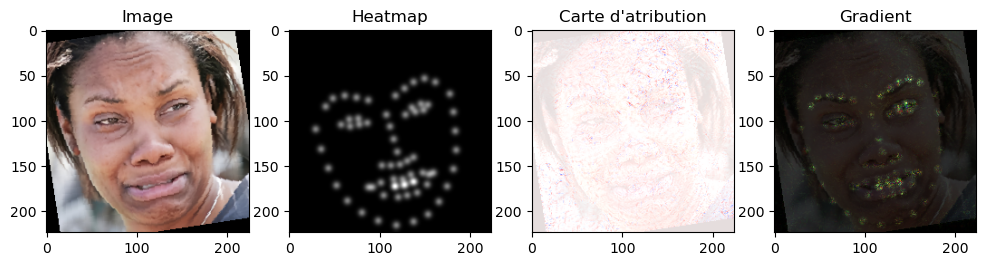

  1%|          | 1/87 [00:09<13:10,  9.19s/it]

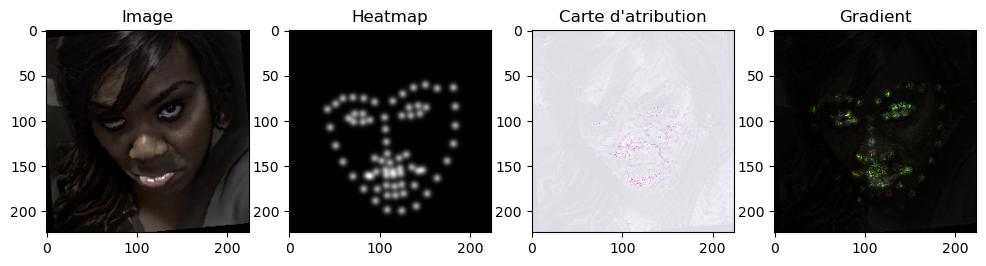

  2%|▏         | 2/87 [00:18<13:09,  9.29s/it]

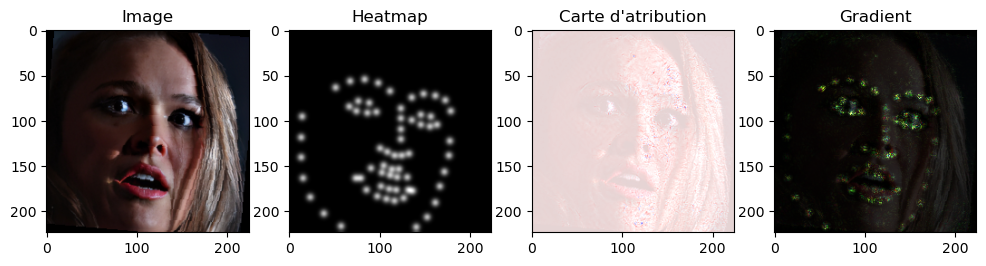

  3%|▎         | 3/87 [00:33<15:45, 11.26s/it]


KeyboardInterrupt: 

In [11]:
# Attacher un hook pour enregistrer le gradient
from matplotlib.colors import LinearSegmentedColormap
import torch
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

criterion = torch.nn.CrossEntropyLoss()
loss_values = [] 
accuracy_values = []  
lr = 4e-5
power = 5

def adjust_learning_rate(optimizer, epoch, num_epochs, initial_lr, power):
    """Ajuste le taux d'apprentissage selon une politique de décroissance polynomiale."""
    lr = initial_lr * (1 - (epoch / num_epochs)) ** power
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch, num_epochs, lr, power)  # Mise à jour du taux d'apprentissage
    model.train()
    running_loss = 0.0
    running_pal_loss = 0.0
    running_corrects = 0.0
    total_samples = 0.0
    k = 0
    for images, labels in tqdm(train_loader):
        k = k + 1
        if k > 50:
            break
        # Initialiser un tenseur pour stocker toutes les heatmaps
        batch_heatmaps = generate_batch_heatmaps(images, heatmap_generator)
            
         # Ensure that images require gradients
        images.requires_grad_()

         # Forward pass
        outputs = model(images)
        labels = labels.long()

        # Calcul de la classification loss
        classification_loss = criterion(outputs, labels)

        # Backward pass for gradients with respect to the input images
        classification_loss.backward(retain_graph=True)  
        gradients = images.grad

        # Compute the attribution maps as the element-wise product of the gradients and the input images
        attribution_maps = gradients * images

        # Compute the PAL loss using the attribution maps and the prior maps
        pal_loss_fn = PrivilegedAttributionLoss()
        pal_loss = pal_loss_fn(attribution_maps, batch_heatmaps)

        # Calcul de la PAL loss et de la classification loss
        total_loss = classification_loss + pal_loss

        # Backpropagation et optimisation
        optimizer.zero_grad()  # Clear gradients before the backward pass
        total_loss.backward()
        optimizer.step()

        # Mise à jour des running loss et PAL loss
        running_loss += classification_loss.item()
        running_pal_loss += pal_loss.item()         

        # Mise à jour des running loss et PAL loss
        running_loss += classification_loss.item()
        running_pal_loss += pal_loss.item()

        # Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        if epoch == 0:
           plot_element(images, batch_heatmaps, attribution_maps, gradients, 0)
    # Calcul des moyennes pour l'époque
    epoch_loss = running_loss / len(train_loader)
    epoch_pal_loss = running_pal_loss / len(train_loader)
    epoch_acc = running_corrects.double() / total_samples

    # Ajouter les valeurs moyennes aux listes
    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_acc)

    # Affichage des résultats pour l'époque
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print(f'Loss: {epoch_loss:.4f}, PAL Loss: {epoch_pal_loss:.4f}, Accuracy: {epoch_acc:.4f}')


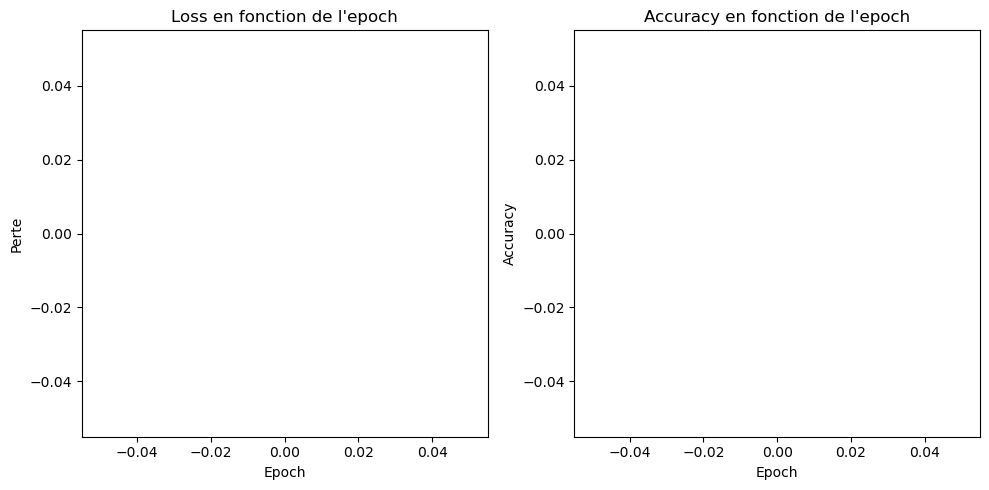

In [12]:
import matplotlib.pyplot as plt

# Liste de longueurs de vecteur que vous souhaitez utiliser
vector_lengths = np.linspace(0, len(loss_values), len(loss_values))

# Plot de la perte en fonction de la longueur du vecteur
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(vector_lengths, loss_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.title("Loss en fonction de l'epoch")

# Plot de la précision en fonction de la longueur du vecteur
plt.subplot(1, 2, 2)
plt.plot(vector_lengths, accuracy_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction de l'epoch")

plt.tight_layout()  # Pour éviter que les titres se chevauchent
plt.show()


In [13]:
model.eval()  # Mettre le modèle en mode évaluation
test_running_corrects = 0.0
test_total_samples = 0.0
test_accuracy_values = []
num_epochs = 10
for epoch   in range(num_epochs):
    with torch.no_grad():  # Désactive le calcul du gradient
            for test_images, test_labels in tqdm(test_loader):
                test_outputs = model(test_images)
                _, test_preds = torch.max(test_outputs, 1)
                test_running_corrects += torch.sum(test_preds == test_labels.data)
                test_total_samples += test_labels.size(0)
        # Calcul de l'accuracy de test pour l'époque
    test_epoch_acc = test_running_corrects.double() / test_total_samples
    test_accuracy_values.append(test_epoch_acc)

    # Afficher les résultats de test pour l'époque
    print(f'Test Accuracy: {test_epoch_acc:.4f}')

  1%|          | 15/1652 [00:29<53:35,  1.96s/it]


KeyboardInterrupt: 